## Usando Keras para Construir uma Rede Neural

Nesse exercício utilizaremos uma rede neural para predizer diabetes usando a base de dados Pima Diabetes. Começaremos os exercícios treinando uma Floresta Aleatória para utilizar como um baseline da performance da rede. Em seguida, utilizaremos o pacote Keras para construir e treinar uma rede neural e comparar a performance. Vamos testar diferentes estruturas de rede e como isso impacta na performance, tempo de treinamento e nível de overfitting.

## UCI Pima Diabetes Dataset

* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

A base de dados possui 8 atributos e uma variável alvo representando uma classe binária

In [1]:
# Importando as bibliotecas necessárias
from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

%matplotlib inline

In [2]:
## Importando Keras

from keras.models  import Sequential, K
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

Using TensorFlow backend.


In [47]:
## Carregando a base de dados diretamente pela url

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv(url, names=names)

In [4]:
# Uma pequena olhada nos dados -- se aparecerem muitos "NaN" você pode estar com problemas de conexão
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
580,0,151,90,46,0,42.1,0.371,21,1
82,7,83,78,26,71,29.3,0.767,36,0
33,6,92,92,0,0,19.9,0.188,28,0
401,6,137,61,0,0,24.2,0.151,55,0
166,3,148,66,25,0,32.5,0.256,22,0


In [5]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [6]:
# Vamos dividir a base entre treino e teste (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

In [7]:
np.mean(y), np.mean(1-y)

(0.34895833333333331, 0.65104166666666663)

In [8]:
np.mean(y_train), np.mean(1-y_train)

(0.3454861111111111, 0.65451388888888884)

In [9]:
np.mean(y_test), np.mean(1-y_test)

(0.359375, 0.640625)

Das estatísticas acima, percebemos que 35% dos pacientes da base tem diabetes e 65% não. Isso significa que podemos obter uma acurácia de 65% sem qualquer modelo, apenas predizendo que ninguém tem diabetes. Para validarmos nosso modelo de redes neurais, calcularemos o AUC e a acurácia para verificar se estamos acima de um baseline simples.

## Exercício: Gerando um baseline com Árvore Aleatória
Para iniciar:
1. Treine uma Floresta Aleatória (várias Árvores de Decisão combinadas) com 200 árvores na base de treino.
2. Calcule a acurácia e auc das predições.

In [56]:
## Treine a floresta aleatória

#n_estimators: number of trees in the forest
#max_features: size of the random subsets of features to consider when splitting a node
#max_depth:    the maximum depth of the tree
#random_state: seed

rf_model = RandomForestClassifier(n_estimators=200, random_state=0)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [58]:
# Faça predições 0/1 e probabilísticas
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)

print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.766
roc-auc is 0.831


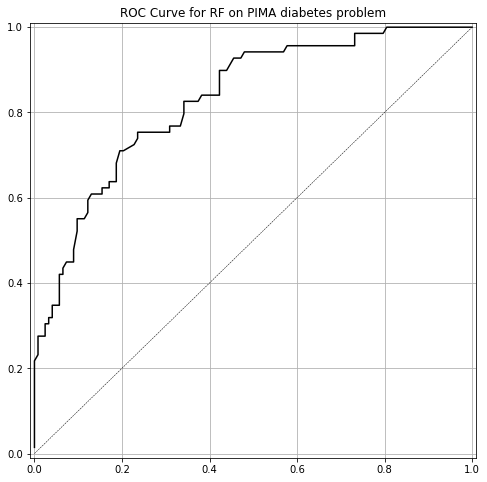

In [59]:
# Vamos plotar a curva ROC-AUC para validar nosso modelo
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])


plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Construindo uma Rede Neural com uma camada escondida

Utilizaremos o modelo Sequential para construir rapidamente uma rede neural. Nossa primeira rede será uma rede neural de uma única camada. Temos 8 variáveis de entrada, então a input shape deve ser 8. Vamos começar com uma única camada escondida com 12 nós.

In [63]:
## Primeiro vamos normalizar os dados
## Isso ajuda o algoritmo de otimização a obter estabilidade numérica.
## Como as Árvores de Decisão trabalham com a divisão de valores atributo a atributo, isso não afeta sua performance

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [64]:
# Vamos construir o modelo
# Input size tem dimensão 8
# 1 camada escondida, 12 neurônios, ativação sigmoid
# A camada final tem apenas um nó com ativação sigmoid (padrão para classificação binária)

model_1 = Sequential([
    Dense(12, input_shape=(8,), activation='sigmoid'),
    Dense(1, activation='sigmoid')
])

In [65]:
#  Vamos verificar um resumo da rede

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


### Questão de compreensão:

Por que  temos 121 parâmetros? Faz sentido?


Vamos ajustar nosso modelo por 200 iterações.

In [66]:
# Vamos compilar com um otimizador, função de erro e métrica de avaliação
# Roc-Auc não está disponível no Keras, vamos pular seu uso por ora

model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200)
# o método fit retorna um histórico que pode ser útil para análise dos parâmetros do modelo

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 576 samples, validate on 192 samples
Epoch 1/200
576/576 [==============================] - 2s 4ms/step - loss: 0.6913 - acc: 0.5573 - val_loss: 0.6866 - val_acc: 0.5729
Epoch 2/200
576/576 [==============================] - 0s 69us/step - loss: 0.6854 - acc: 0.6111 - val_loss: 0.6814 - val_acc: 0.5781
Epoch 3/200
576/576 [==============================] - 0s 43us/step - loss: 0.6801 - acc: 0.6233 - val_loss: 0.6767 - val_acc: 0.6042
Epoch 4/200
576/576 [==============================] - 0s 87us/step - loss: 0.6753 - acc: 0.6389 - val_loss: 0.6725 - val_acc: 0.6042
Epoch 5/200
576/576 [==============================] - 0s 57us/step - loss: 0.6710 - acc: 0.6458 - val_loss: 0.6686 - val_acc: 0.6250
Epoch 6/200
576/576 [==============================] - 0s 115us/step - loss: 0.6670 - acc: 0.6493 - val_loss: 0.6651 - val_acc: 0.6406
Epoch 7/200
576/576 [==============================] - 0s 75us/step - loss: 0

576/576 [==============================] - 0s 71us/step - loss: 0.5846 - acc: 0.6649 - val_loss: 0.5891 - val_acc: 0.6667
Epoch 120/200
576/576 [==============================] - ETA: 0s - loss: 0.6695 - acc: 0.531 - 0s 76us/step - loss: 0.5842 - acc: 0.6649 - val_loss: 0.5887 - val_acc: 0.6667
Epoch 121/200
576/576 [==============================] - 0s 85us/step - loss: 0.5838 - acc: 0.6649 - val_loss: 0.5883 - val_acc: 0.6667
Epoch 122/200
576/576 [==============================] - 0s 49us/step - loss: 0.5834 - acc: 0.6649 - val_loss: 0.5879 - val_acc: 0.6667
Epoch 123/200
576/576 [==============================] - 0s 130us/step - loss: 0.5831 - acc: 0.6667 - val_loss: 0.5876 - val_acc: 0.6667
Epoch 124/200
576/576 [==============================] - 0s 144us/step - loss: 0.5826 - acc: 0.6684 - val_loss: 0.5872 - val_acc: 0.6667
Epoch 125/200
576/576 [==============================] - 0s 54us/step - loss: 0.5823 - acc: 0.6684 - val_loss: 0.5868 - val_acc: 0.6719
Epoch 126/200
576/576 

In [69]:
## Da mesma forma que fizemos com o Random Forest, vamos gerar as predições
#  com predict_classes (0/1) e predict (probabilidade)

y_pred_class_nn_1 = model_1.predict_classes(X_test_norm)
y_pred_prob_nn_1 = model_1.predict(X_test_norm)

192/192 [==============================] - 0s 26us/step


In [70]:
# Vamos verificar as 10 primeiras predições
y_pred_class_nn_1[:10]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0]])

In [71]:
y_pred_prob_nn_1[:10]

array([[ 0.36724502],
       [ 0.56340599],
       [ 0.32496291],
       [ 0.38223127],
       [ 0.23619023],
       [ 0.42656457],
       [ 0.20548928],
       [ 0.39709237],
       [ 0.53303063],
       [ 0.3528029 ]], dtype=float32)

accuracy is 0.719
roc-auc is 0.797


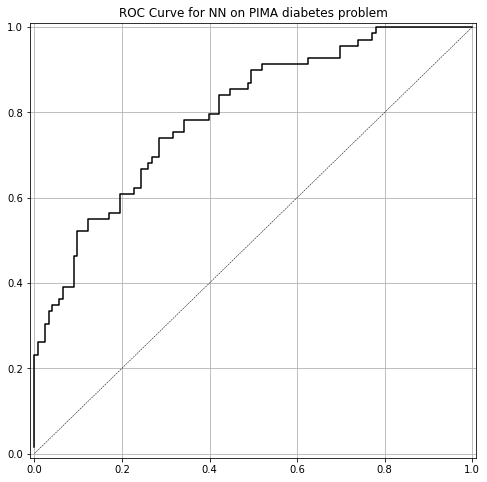

In [72]:
# Vamos imprimir a acurácia, roc-auc e plotar a curva ROC-AUC
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

Podem haver variações nos números exatos por conta da aleatoriedade, mas você deve obter resultados similares ao Random Forest, entre 75% e 85% de acurácia e entre .8 e .9 para auc.

Vamos ver o que o objeto  `run_hist_1`  contém.

In [73]:
run_hist_1.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Vamos utilizar o histórico para plotar o erro de treino ao longo das gerações.

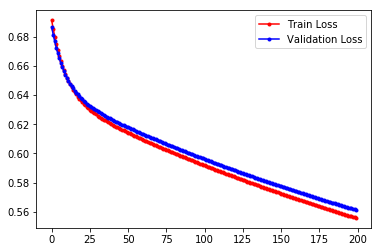

In [74]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Reparem que os erros parecem estar caindo tanto para o conjunto de treino como de validação. Isso sugere que o modelo ainda poderia melhorar com mais algumas gerações.

Vamos treinar o modelo um pouco mais, note que ele não reinicia do zero, mas começará de onde parou. Treine por mais 1000 iterações.

In [75]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

Train on 576 samples, validate on 192 samples
Epoch 1/1000
576/576 [==============================] - 0s 40us/step - loss: 0.5555 - acc: 0.7066 - val_loss: 0.5611 - val_acc: 0.7188
Epoch 2/1000
576/576 [==============================] - 0s 36us/step - loss: 0.5552 - acc: 0.7066 - val_loss: 0.5608 - val_acc: 0.7240
Epoch 3/1000
576/576 [==============================] - 0s 80us/step - loss: 0.5548 - acc: 0.7066 - val_loss: 0.5605 - val_acc: 0.7292
Epoch 4/1000
576/576 [==============================] - 0s 40us/step - loss: 0.5545 - acc: 0.7066 - val_loss: 0.5602 - val_acc: 0.7292
Epoch 5/1000
576/576 [==============================] - 0s 71us/step - loss: 0.5542 - acc: 0.7066 - val_loss: 0.5599 - val_acc: 0.7292
Epoch 6/1000
576/576 [==============================] - 0s 61us/step - loss: 0.5539 - acc: 0.7083 - val_loss: 0.5596 - val_acc: 0.7292
Epoch 7/1000
576/576 [==============================] - 0s 80us/step - loss: 0.5536 - acc: 0.7083 - val_loss: 0.5593 - val_acc: 0.7292
Epoch 8/1

Epoch 61/1000
576/576 [==============================] - 0s 99us/step - loss: 0.5378 - acc: 0.7309 - val_loss: 0.5445 - val_acc: 0.7344
Epoch 62/1000
576/576 [==============================] - 0s 90us/step - loss: 0.5375 - acc: 0.7326 - val_loss: 0.5443 - val_acc: 0.7344
Epoch 63/1000
576/576 [==============================] - 0s 109us/step - loss: 0.5372 - acc: 0.7326 - val_loss: 0.5440 - val_acc: 0.7344
Epoch 64/1000
576/576 [==============================] - 0s 55us/step - loss: 0.5370 - acc: 0.7344 - val_loss: 0.5438 - val_acc: 0.7344
Epoch 65/1000
576/576 [==============================] - 0s 93us/step - loss: 0.5367 - acc: 0.7344 - val_loss: 0.5435 - val_acc: 0.7344
Epoch 66/1000
576/576 [==============================] - 0s 123us/step - loss: 0.5364 - acc: 0.7344 - val_loss: 0.5433 - val_acc: 0.7344
Epoch 67/1000
576/576 [==============================] - 0s 89us/step - loss: 0.5362 - acc: 0.7361 - val_loss: 0.5431 - val_acc: 0.7344
Epoch 68/1000
576/576 [=======================

576/576 [==============================] - 0s 59us/step - loss: 0.5110 - acc: 0.7517 - val_loss: 0.5206 - val_acc: 0.7552
Epoch 181/1000
576/576 [==============================] - 0s 68us/step - loss: 0.5108 - acc: 0.7517 - val_loss: 0.5204 - val_acc: 0.7552
Epoch 182/1000
576/576 [==============================] - 0s 56us/step - loss: 0.5106 - acc: 0.7517 - val_loss: 0.5203 - val_acc: 0.7552
Epoch 183/1000
576/576 [==============================] - 0s 85us/step - loss: 0.5104 - acc: 0.7517 - val_loss: 0.5201 - val_acc: 0.7552
Epoch 184/1000
576/576 [==============================] - 0s 75us/step - loss: 0.5102 - acc: 0.7517 - val_loss: 0.5200 - val_acc: 0.7552
Epoch 185/1000
576/576 [==============================] - 0s 69us/step - loss: 0.5100 - acc: 0.7517 - val_loss: 0.5198 - val_acc: 0.7552
Epoch 186/1000
576/576 [==============================] - 0s 68us/step - loss: 0.5099 - acc: 0.7517 - val_loss: 0.5197 - val_acc: 0.7552
Epoch 187/1000
576/576 [==============================] 

Epoch 240/1000
576/576 [==============================] - 0s 73us/step - loss: 0.5009 - acc: 0.7569 - val_loss: 0.5123 - val_acc: 0.7760
Epoch 241/1000
576/576 [==============================] - 0s 82us/step - loss: 0.5008 - acc: 0.7569 - val_loss: 0.5121 - val_acc: 0.7760
Epoch 242/1000
576/576 [==============================] - 0s 54us/step - loss: 0.5007 - acc: 0.7569 - val_loss: 0.5120 - val_acc: 0.7760
Epoch 243/1000
576/576 [==============================] - 0s 64us/step - loss: 0.5005 - acc: 0.7569 - val_loss: 0.5119 - val_acc: 0.7760
Epoch 244/1000
576/576 [==============================] - 0s 95us/step - loss: 0.5004 - acc: 0.7569 - val_loss: 0.5118 - val_acc: 0.7760
Epoch 245/1000
576/576 [==============================] - 0s 141us/step - loss: 0.5002 - acc: 0.7569 - val_loss: 0.5117 - val_acc: 0.7760
Epoch 246/1000
576/576 [==============================] - 0s 87us/step - loss: 0.5001 - acc: 0.7552 - val_loss: 0.5116 - val_acc: 0.7760
Epoch 247/1000
576/576 [================

Epoch 300/1000
576/576 [==============================] - 0s 73us/step - loss: 0.4928 - acc: 0.7587 - val_loss: 0.5059 - val_acc: 0.7812
Epoch 301/1000
576/576 [==============================] - 0s 69us/step - loss: 0.4927 - acc: 0.7587 - val_loss: 0.5058 - val_acc: 0.7812
Epoch 302/1000
576/576 [==============================] - 0s 97us/step - loss: 0.4926 - acc: 0.7604 - val_loss: 0.5057 - val_acc: 0.7812
Epoch 303/1000
576/576 [==============================] - 0s 56us/step - loss: 0.4925 - acc: 0.7604 - val_loss: 0.5056 - val_acc: 0.7812
Epoch 304/1000
576/576 [==============================] - 0s 95us/step - loss: 0.4924 - acc: 0.7587 - val_loss: 0.5055 - val_acc: 0.7812
Epoch 305/1000
576/576 [==============================] - 0s 69us/step - loss: 0.4923 - acc: 0.7587 - val_loss: 0.5054 - val_acc: 0.7812
Epoch 306/1000
576/576 [==============================] - 0s 78us/step - loss: 0.4921 - acc: 0.7587 - val_loss: 0.5053 - val_acc: 0.7812
Epoch 307/1000
576/576 [=================

Epoch 360/1000
576/576 [==============================] - 0s 76us/step - loss: 0.4863 - acc: 0.7622 - val_loss: 0.5010 - val_acc: 0.7708
Epoch 361/1000
576/576 [==============================] - 0s 56us/step - loss: 0.4861 - acc: 0.7622 - val_loss: 0.5010 - val_acc: 0.7708
Epoch 362/1000
576/576 [==============================] - 0s 80us/step - loss: 0.4860 - acc: 0.7622 - val_loss: 0.5009 - val_acc: 0.7708
Epoch 363/1000
576/576 [==============================] - 0s 83us/step - loss: 0.4860 - acc: 0.7639 - val_loss: 0.5008 - val_acc: 0.7708
Epoch 364/1000
576/576 [==============================] - ETA: 0s - loss: 0.4763 - acc: 0.750 - 0s 82us/step - loss: 0.4859 - acc: 0.7639 - val_loss: 0.5008 - val_acc: 0.7708
Epoch 365/1000
576/576 [==============================] - 0s 70us/step - loss: 0.4858 - acc: 0.7639 - val_loss: 0.5007 - val_acc: 0.7708
Epoch 366/1000
576/576 [==============================] - 0s 68us/step - loss: 0.4857 - acc: 0.7639 - val_loss: 0.5006 - val_acc: 0.7708
Epo

Epoch 479/1000
576/576 [==============================] - 0s 78us/step - loss: 0.4766 - acc: 0.7639 - val_loss: 0.4946 - val_acc: 0.7656
Epoch 480/1000
576/576 [==============================] - 0s 71us/step - loss: 0.4765 - acc: 0.7639 - val_loss: 0.4946 - val_acc: 0.7656
Epoch 481/1000
576/576 [==============================] - 0s 85us/step - loss: 0.4765 - acc: 0.7639 - val_loss: 0.4946 - val_acc: 0.7656
Epoch 482/1000
576/576 [==============================] - 0s 59us/step - loss: 0.4764 - acc: 0.7639 - val_loss: 0.4945 - val_acc: 0.7656
Epoch 483/1000
576/576 [==============================] - 0s 89us/step - loss: 0.4763 - acc: 0.7639 - val_loss: 0.4945 - val_acc: 0.7656
Epoch 484/1000
576/576 [==============================] - 0s 70us/step - loss: 0.4763 - acc: 0.7639 - val_loss: 0.4944 - val_acc: 0.7656
Epoch 485/1000
576/576 [==============================] - 0s 92us/step - loss: 0.4762 - acc: 0.7639 - val_loss: 0.4944 - val_acc: 0.7656
Epoch 486/1000
576/576 [=================

Epoch 539/1000
576/576 [==============================] - 0s 69us/step - loss: 0.4730 - acc: 0.7656 - val_loss: 0.4926 - val_acc: 0.7604
Epoch 540/1000
576/576 [==============================] - 0s 52us/step - loss: 0.4729 - acc: 0.7639 - val_loss: 0.4925 - val_acc: 0.7604
Epoch 541/1000
576/576 [==============================] - 0s 83us/step - loss: 0.4729 - acc: 0.7639 - val_loss: 0.4925 - val_acc: 0.7604
Epoch 542/1000
576/576 [==============================] - 0s 90us/step - loss: 0.4729 - acc: 0.7656 - val_loss: 0.4925 - val_acc: 0.7604
Epoch 543/1000
576/576 [==============================] - 0s 75us/step - loss: 0.4728 - acc: 0.7639 - val_loss: 0.4924 - val_acc: 0.7604
Epoch 544/1000
576/576 [==============================] - 0s 94us/step - loss: 0.4727 - acc: 0.7639 - val_loss: 0.4924 - val_acc: 0.7604
Epoch 545/1000
576/576 [==============================] - 0s 66us/step - loss: 0.4727 - acc: 0.7639 - val_loss: 0.4924 - val_acc: 0.7604
Epoch 546/1000
576/576 [=================

Epoch 599/1000
576/576 [==============================] - 0s 45us/step - loss: 0.4701 - acc: 0.7674 - val_loss: 0.4910 - val_acc: 0.7552
Epoch 600/1000
576/576 [==============================] - 0s 85us/step - loss: 0.4700 - acc: 0.7674 - val_loss: 0.4910 - val_acc: 0.7552
Epoch 601/1000
576/576 [==============================] - 0s 115us/step - loss: 0.4700 - acc: 0.7674 - val_loss: 0.4910 - val_acc: 0.7552
Epoch 602/1000
576/576 [==============================] - 0s 80us/step - loss: 0.4699 - acc: 0.7674 - val_loss: 0.4910 - val_acc: 0.7552
Epoch 603/1000
576/576 [==============================] - 0s 82us/step - loss: 0.4699 - acc: 0.7674 - val_loss: 0.4909 - val_acc: 0.7552
Epoch 604/1000
576/576 [==============================] - 0s 76us/step - loss: 0.4698 - acc: 0.7656 - val_loss: 0.4909 - val_acc: 0.7552
Epoch 605/1000
576/576 [==============================] - 0s 66us/step - loss: 0.4698 - acc: 0.7656 - val_loss: 0.4909 - val_acc: 0.7552
Epoch 606/1000
576/576 [================

576/576 [==============================] - 0s 63us/step - loss: 0.4657 - acc: 0.7726 - val_loss: 0.4891 - val_acc: 0.7500
Epoch 718/1000
576/576 [==============================] - 0s 61us/step - loss: 0.4657 - acc: 0.7726 - val_loss: 0.4891 - val_acc: 0.7500
Epoch 719/1000
576/576 [==============================] - 0s 45us/step - loss: 0.4657 - acc: 0.7726 - val_loss: 0.4891 - val_acc: 0.7500
Epoch 720/1000
576/576 [==============================] - 0s 87us/step - loss: 0.4656 - acc: 0.7743 - val_loss: 0.4891 - val_acc: 0.7500
Epoch 721/1000
576/576 [==============================] - 0s 115us/step - loss: 0.4656 - acc: 0.7726 - val_loss: 0.4891 - val_acc: 0.7500
Epoch 722/1000
576/576 [==============================] - 0s 69us/step - loss: 0.4656 - acc: 0.7743 - val_loss: 0.4891 - val_acc: 0.7500
Epoch 723/1000
576/576 [==============================] - 0s 59us/step - loss: 0.4656 - acc: 0.7743 - val_loss: 0.4890 - val_acc: 0.7500
Epoch 724/1000
576/576 [==============================]

Epoch 777/1000
576/576 [==============================] - 0s 68us/step - loss: 0.4641 - acc: 0.7760 - val_loss: 0.4885 - val_acc: 0.7552
Epoch 778/1000
576/576 [==============================] - 0s 64us/step - loss: 0.4641 - acc: 0.7760 - val_loss: 0.4885 - val_acc: 0.7552
Epoch 779/1000
576/576 [==============================] - 0s 80us/step - loss: 0.4640 - acc: 0.7760 - val_loss: 0.4885 - val_acc: 0.7552
Epoch 780/1000
576/576 [==============================] - 0s 82us/step - loss: 0.4640 - acc: 0.7760 - val_loss: 0.4885 - val_acc: 0.7552
Epoch 781/1000
576/576 [==============================] - 0s 76us/step - loss: 0.4640 - acc: 0.7760 - val_loss: 0.4885 - val_acc: 0.7552
Epoch 782/1000
576/576 [==============================] - 0s 71us/step - loss: 0.4640 - acc: 0.7760 - val_loss: 0.4885 - val_acc: 0.7552
Epoch 783/1000
576/576 [==============================] - 0s 75us/step - loss: 0.4639 - acc: 0.7778 - val_loss: 0.4885 - val_acc: 0.7552
Epoch 784/1000
576/576 [=================

Epoch 837/1000
576/576 [==============================] - 0s 68us/step - loss: 0.4627 - acc: 0.7778 - val_loss: 0.4881 - val_acc: 0.7552
Epoch 838/1000
576/576 [==============================] - 0s 64us/step - loss: 0.4627 - acc: 0.7778 - val_loss: 0.4881 - val_acc: 0.7552
Epoch 839/1000
576/576 [==============================] - 0s 85us/step - loss: 0.4627 - acc: 0.7778 - val_loss: 0.4881 - val_acc: 0.7552
Epoch 840/1000
576/576 [==============================] - 0s 96us/step - loss: 0.4627 - acc: 0.7778 - val_loss: 0.4881 - val_acc: 0.7552
Epoch 841/1000
576/576 [==============================] - 0s 71us/step - loss: 0.4626 - acc: 0.7778 - val_loss: 0.4881 - val_acc: 0.7552
Epoch 842/1000
576/576 [==============================] - 0s 68us/step - loss: 0.4626 - acc: 0.7778 - val_loss: 0.4881 - val_acc: 0.7552
Epoch 843/1000
576/576 [==============================] - 0s 59us/step - loss: 0.4626 - acc: 0.7778 - val_loss: 0.4881 - val_acc: 0.7552
Epoch 844/1000
576/576 [=================

576/576 [==============================] - 0s 68us/step - loss: 0.4606 - acc: 0.7726 - val_loss: 0.4877 - val_acc: 0.7500
Epoch 956/1000
576/576 [==============================] - 0s 63us/step - loss: 0.4606 - acc: 0.7726 - val_loss: 0.4877 - val_acc: 0.7500
Epoch 957/1000
576/576 [==============================] - 0s 87us/step - loss: 0.4606 - acc: 0.7726 - val_loss: 0.4877 - val_acc: 0.7500
Epoch 958/1000
576/576 [==============================] - 0s 94us/step - loss: 0.4606 - acc: 0.7726 - val_loss: 0.4877 - val_acc: 0.7500
Epoch 959/1000
576/576 [==============================] - 0s 54us/step - loss: 0.4606 - acc: 0.7726 - val_loss: 0.4877 - val_acc: 0.7500
Epoch 960/1000
576/576 [==============================] - 0s 66us/step - loss: 0.4605 - acc: 0.7726 - val_loss: 0.4877 - val_acc: 0.7500
Epoch 961/1000
576/576 [==============================] - 0s 73us/step - loss: 0.4605 - acc: 0.7726 - val_loss: 0.4877 - val_acc: 0.7500
Epoch 962/1000
576/576 [==============================] 

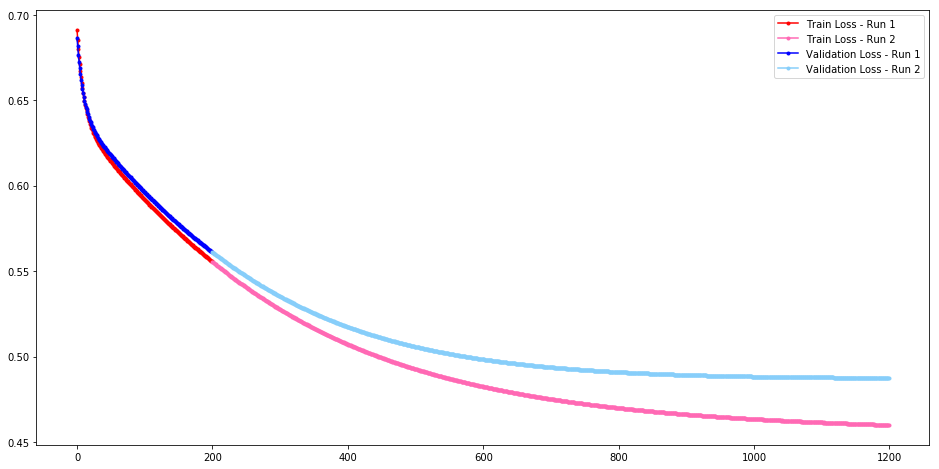

In [76]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Agora, enquanto o erro de treino continua caindo, o de validação parece ter começado a piorar. Isso sugere que não devemos continuar com o treino. Qual o número apropriado de iterações?

## Exercício

Repita os experimentos anteriores, sem ajuda:
- Construa um modelo com duas camadas escondidas, cada uma com 6 nós
- Use a ativação "relu" nas camadas escondidas e "sigmoid" para a camada final
- Com uma taxa de aprendizado de .003 treine por 1500 iterações
- Plote o erro e a acurácia na base de treino e teste ao longo das iterações
- Plote a curva ROC-AUC para as predições

Teste diferentes taxas de aprendizado, número de iterações e estruturas de rede

In [1]:
model_2 = Sequential([
    Dense(6, input_shape=(8,), activation='relu'),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_2.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_2 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1500)

NameError: name 'Sequential' is not defined

In [ ]:
#cant complete the test due to unavailability of the databse
#all missing code though can be found above